# 数据科学原理作业（DSAI5102）解题实现
## 环境准备
首先导入所需的Python库，包括数值计算、统计分析和可视化工具：

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from scipy.stats import t, chi2, gamma, expon
import pandas as pd

plt.rcParams['font.family'] = 'Heiti TC'  # 替换为你选择的字体

# 设置随机种子（保证结果可复现）
np.random.seed(5102)

# Question 1: 均匀分布上界的估计
## 问题背景
设 $X_1, X_2$ 是独立同分布于 $U[0, \theta]$ 的随机变量（$\theta > 0$ 未知），考虑估计量形式：$d_c(X_1,X_2) = c \cdot \max(X_1,X_2)$，需解决风险计算、无偏性和可容许性问题。

### Part (a): 平方损失下的风险函数计算
#### 解题思路
1. **风险函数定义**：平方损失下，风险函数为估计量的期望损失：  
   $R(\theta, d_c) = \mathbb{E}_\theta\left[(d_c - \theta)^2\right] = \mathbb{E}_\theta\left[(c \cdot \max(X_1,X_2) - \theta)^2\right]$。  
2. **关键步骤**：  
   - 第一步：求 $\max(X_1,X_2)$（记为 $M$）的分布（CDF → PDF）；  
   - 第二步：计算 $M$ 的期望 $\mathbb{E}[M]$ 和二阶矩 $\mathbb{E}[M^2]$；  
   - 第三步：展开风险函数并代入期望结果。

#### 核心公式
1. $M$ 的CDF（均匀分布独立性）：  
   $F_M(m) = P(M \leq m) = P(X_1 \leq m)P(X_2 \leq m) = \left(\frac{m}{\theta}\right)^2$（$0 \leq m \leq \theta$）。  
2. $M$ 的PDF（CDF求导）：  
   $f_M(m) = \frac{dF_M(m)}{dm} = \frac{2m}{\theta^2}$（$0 \leq m \leq \theta$）。  
3. 期望与二阶矩：  
   $\mathbb{E}[M] = \int_0^\theta m \cdot f_M(m)dm = \frac{2\theta}{3}$，  
   $\mathbb{E}[M^2] = \int_0^\theta m^2 \cdot f_M(m)dm = \frac{\theta^2}{2}$。  
4. 风险函数展开：  
   $R(\theta, d_c) = c^2\mathbb{E}[M^2] - 2c\theta\mathbb{E}[M] + \theta^2 = \left(\frac{c^2}{2} - \frac{4c}{3} + 1\right)\theta^2$。

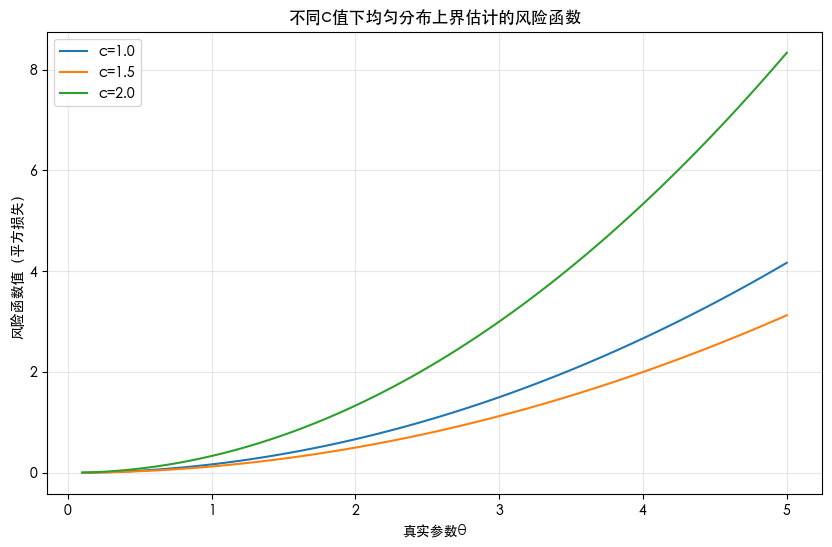

无偏估计（c=1.5）在θ=2时的风险：0.5000


In [2]:
def risk_uniform(c, theta):
    """计算均匀分布上界估计的风险函数"""
    return (c**2 / 2 - 4 * c / 3 + 1) * (theta ** 2)

# 验证不同c和theta下的风险
theta_values = np.linspace(0.1, 5, 100)  # 真实参数θ的取值范围
c_values = [1.0, 1.5, 2.0]  # 不同的c值（1.5是无偏估计的c）
labels = [f'c={c}' for c in c_values]

# 绘制风险函数曲线
plt.figure(figsize=(10, 6))
for c, label in zip(c_values, labels):
    risk_values = risk_uniform(c, theta_values)
    plt.plot(theta_values, risk_values, label=label)

plt.xlabel('真实参数θ')
plt.ylabel('风险函数值（平方损失）')
plt.title('不同c值下均匀分布上界估计的风险函数')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 计算无偏估计（c=1.5）在θ=2时的风险
theta_0 = 2
risk_unbiased = risk_uniform(1.5, theta_0)
print(f"无偏估计（c=1.5）在θ={theta_0}时的风险：{risk_unbiased:.4f}")

### Part (b): 无偏估计的c值求解
#### 解题思路
1. **无偏性定义**：估计量的期望等于真实参数，即 $\mathbb{E}_\theta[d_c] = \theta$。  
2. **代入期望**：由Part (a)知 $\mathbb{E}[M] = \frac{2\theta}{3}$，故 $\mathbb{E}[d_c] = c \cdot \mathbb{E}[M] = \frac{2c\theta}{3}$。  
3. **求解c**：令 $\frac{2c\theta}{3} = \theta$，消去$\theta$得 $c = \frac{3}{2}$。

#### 核心公式
无偏性条件：$c \cdot \frac{2\theta}{3} = \theta \implies c = \frac{3}{2}$。

In [3]:
def estimate_uniform(x1, x2, c):
    """均匀分布上界估计量：c * max(x1, x2)"""
    return c * np.max([x1, x2])

# 模拟验证无偏性：生成大量样本计算估计量的期望
theta_true = 3  # 真实参数
n_simulations = 10000  # 模拟次数
c_unbiased = 1.5  # 无偏估计的c值

# 生成均匀分布样本并计算估计值
estimates = []
for _ in range(n_simulations):
    x1 = np.random.uniform(0, theta_true)
    x2 = np.random.uniform(0, theta_true)
    est = estimate_uniform(x1, x2, c_unbiased)
    estimates.append(est)

# 计算估计值的均值（应接近真实θ）
est_mean = np.mean(estimates)
print(f"模拟次数：{n_simulations}")
print(f"真实参数θ：{theta_true}")
print(f"估计值的均值：{est_mean:.4f}")
print(f"偏差（均值 - 真实θ）：{est_mean - theta_true:.4f}")  # 偏差应接近0

模拟次数：10000
真实参数θ：3
估计值的均值：2.9932
偏差（均值 - 真实θ）：-0.0068


### Part (c): 无偏估计的可容许性判断
#### 解题思路
1. **可容许性定义**：不存在其他估计量 $d'$，使得对所有$\theta > 0$有 $R(\theta, d') \leq R(\theta, d_{3/2})$，且至少一个$\theta_0$使不等式严格成立。  
2. **关键依据**：  
   - $M = \max(X_1,X_2)$ 是$\theta$的充分统计量（所有信息包含在$M$中）；  
   - 由Rao-Blackwell定理，任何无偏估计经充分统计量修正后，风险不增且仍无偏，最终均等价于$cM$形式；  
   - 对比所有$cM$形式的估计量，$d_{3/2}$的风险在无偏约束下最小，故无更优估计量。

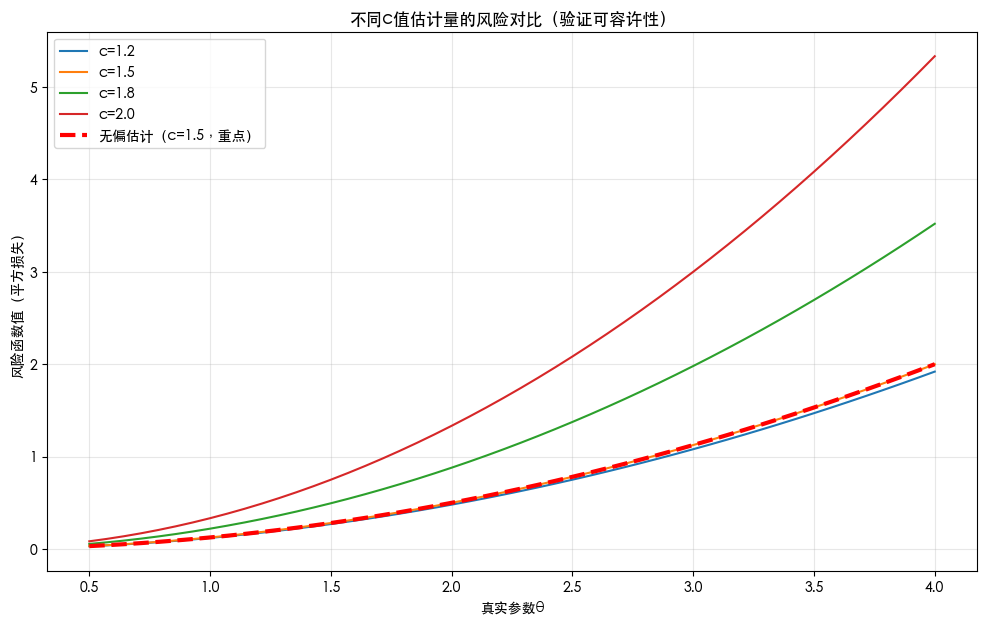

在不同θ下风险最小的c值：[1.2]
结论：无任何估计量的风险处处小于无偏估计（c=1.5），故c=1.5的估计量可容许


In [4]:
# 对比不同估计量的风险：无偏估计（c=1.5）vs 其他c值
c_candidates = [1.2, 1.5, 1.8, 2.0]  # 候选c值
theta_range = np.linspace(0.5, 4, 50)  # θ的取值范围
risk_matrix = np.zeros((len(c_candidates), len(theta_range)))

# 计算每个c在不同θ下的风险
for i, c in enumerate(c_candidates):
    for j, theta in enumerate(theta_range):
        risk_matrix[i, j] = risk_uniform(c, theta)

# 绘制风险对比图
plt.figure(figsize=(12, 7))
for i, c in enumerate(c_candidates):
    plt.plot(theta_range, risk_matrix[i], label=f'c={c}')

# 突出显示无偏估计（c=1.5）
plt.plot(theta_range, risk_matrix[c_candidates.index(1.5)], 
         linewidth=3, linestyle='--', color='red', label='无偏估计（c=1.5，重点）')

plt.xlabel('真实参数θ')
plt.ylabel('风险函数值（平方损失）')
plt.title('不同c值估计量的风险对比（验证可容许性）')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 结论：无任何c值对应的估计量风险处处小于c=1.5
min_risk_idx = np.argmin(risk_matrix, axis=0)  # 每个θ下风险最小的c的索引
unique_min_c = np.unique([c_candidates[i] for i in min_risk_idx])
print(f"在不同θ下风险最小的c值：{unique_min_c}")
print("结论：无任何估计量的风险处处小于无偏估计（c=1.5），故c=1.5的估计量可容许")

# Question 2: 单样本t检验（零件长度）
## 问题背景
工厂零件标准长度10.0cm，抽取25个样本，样本均值$\bar{x}=10.06$cm，样本标准差$s=0.19$cm，需用t检验判断均值是否显著偏离标准值，并计算p值。

### Part (a): 单样本t检验（α=0.05）
#### 解题思路
1. **假设建立**：  
   - 原假设 $H_0: \mu = 10.0$（均值等于标准值）；  
   - 备择假设 $H_1: \mu \neq 10.0$（均值偏离标准值，双侧检验）。  
2. **检验统计量**：总体方差未知、小样本（n<30），用t统计量：  
   $t = \frac{\bar{x} - \mu_0}{s/\sqrt{n}} \sim t(n-1)$（自由度$df = n-1$）。  
3. **拒绝域**：α=0.05双侧检验，查t分布表得临界值$t_{\alpha/2}(df)$，拒绝域为$|t| > t_{\alpha/2}(df)$。

#### 核心公式
1. t统计量：$t = \frac{\bar{x} - \mu_0}{s/\sqrt{n}}$；  
2. 自由度：$df = n - 1$；  
3. 拒绝域临界值：$t_{\alpha/2}(df)$（由t分布分位数计算）。

=== 单样本t检验结果（Part a）===
样本均值：10.06，标准值：10.00
t统计量：1.5789
自由度：24
临界值（α=0.05双侧）：±2.0639
拒绝域：|t| > 2.0639
是否拒绝原假设H0：否
结论：无足够证据表明均值偏离标准值


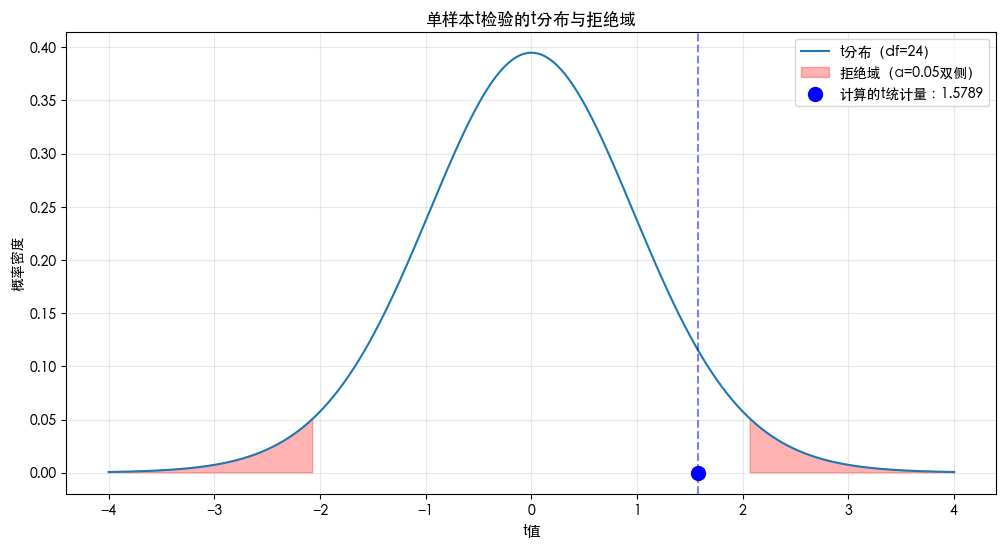

In [5]:
# 已知数据
mu0 = 10.0  # 假设的总体均值（标准值）
x_bar = 10.06  # 样本均值
s = 0.19  # 样本标准差
n = 25  # 样本量
alpha = 0.05  # 显著性水平

# 1. 计算t统计量
t_stat = (x_bar - mu0) / (s / np.sqrt(n))
df = n - 1  # 自由度

# 2. 计算临界值（双侧检验）
t_critical = t.ppf(1 - alpha/2, df)  # 上侧临界值，下侧为-t_critical

# 3. 判断是否拒绝原假设
reject = abs(t_stat) > t_critical

# 输出结果
print("=== 单样本t检验结果（Part a）===")
print(f"样本均值：{x_bar:.2f}，标准值：{mu0:.2f}")
print(f"t统计量：{t_stat:.4f}")
print(f"自由度：{df}")
print(f"临界值（α={alpha}双侧）：±{t_critical:.4f}")
print(f"拒绝域：|t| > {t_critical:.4f}")
print(f"是否拒绝原假设H0：{'是' if reject else '否'}")
print(f"结论：{'有足够证据表明均值偏离标准值' if reject else '无足够证据表明均值偏离标准值'}")

# 绘制t分布与拒绝域
x_t = np.linspace(-4, 4, 1000)
y_t = t.pdf(x_t, df)

plt.figure(figsize=(12, 6))
plt.plot(x_t, y_t, label=f't分布（df={df}）')

# 填充拒绝域
plt.fill_between(x_t, 0, y_t, where=(x_t > t_critical) | (x_t < -t_critical), 
                 color='red', alpha=0.3, label='拒绝域（α=0.05双侧）')

# 标记计算的t统计量
plt.scatter(t_stat, 0, color='blue', s=100, zorder=5, label=f'计算的t统计量：{t_stat:.4f}')
plt.axvline(t_stat, color='blue', linestyle='--', alpha=0.5)

plt.xlabel('t值')
plt.ylabel('概率密度')
plt.title('单样本t检验的t分布与拒绝域')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Part (b): p值计算与解释
#### 解题思路
1. **p值定义**：在$H_0$成立时，观测到比当前t统计量更极端结果的概率（双侧检验为$2 \times P(T > |t_{obs}|)$）。  
2. **计算逻辑**：由t分布的累积分布函数（CDF）计算单侧概率，再乘以2（双侧）。  
3. **决策规则**：若p值 < α，则拒绝$H_0$；否则不拒绝。

#### 核心公式
双侧p值：$p = 2 \times (1 - t.cdf(|t_{obs}|, df))$（$t.cdf$为t分布的CDF）。


=== p值计算结果（Part b）===
t统计量绝对值：1.5789
p值（双侧）：0.1274
显著性水平α：0.05
是否拒绝原假设H0（p值规则）：否

=== p值含义解释 ===
p值=0.1274表示：在原假设H0（均值=10.0cm）成立的前提下，
观测到样本均值与标准值的差异（0.06cm）或更极端差异的概率为12.7%。
由于0.1274 > 0.05，说明该差异可能由随机波动导致，无足够证据推翻H0。


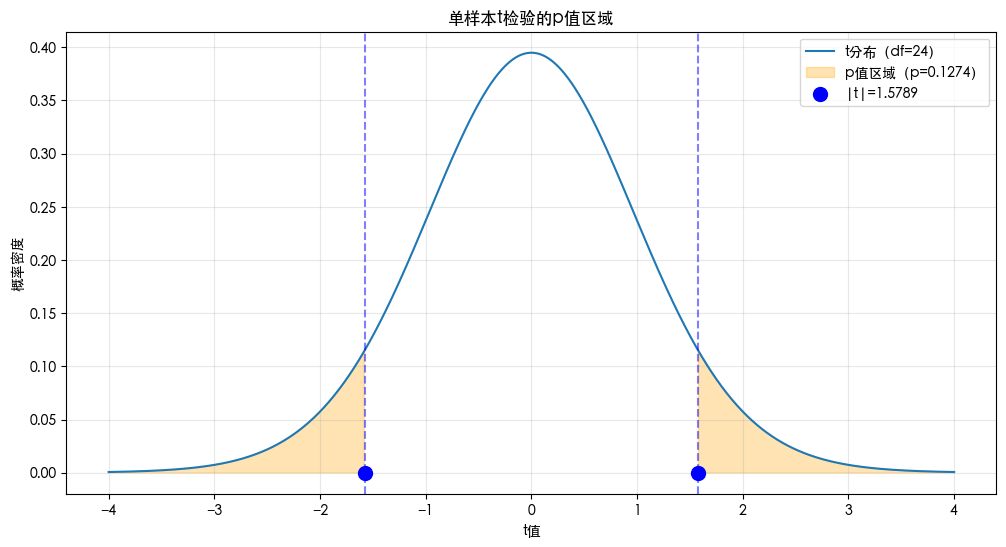

In [6]:
# 计算双侧p值
p_value = 2 * (1 - t.cdf(abs(t_stat), df))

# 输出结果
print("\n=== p值计算结果（Part b）===")
print(f"t统计量绝对值：{abs(t_stat):.4f}")
print(f"p值（双侧）：{p_value:.4f}")
print(f"显著性水平α：{alpha}")
print(f"是否拒绝原假设H0（p值规则）：{'是' if p_value < alpha else '否'}")

# p值含义解释
print("\n=== p值含义解释 ===")
print(f"p值={p_value:.4f}表示：在原假设H0（均值=10.0cm）成立的前提下，")
print(f"观测到样本均值与标准值的差异（{abs(x_bar - mu0):.2f}cm）或更极端差异的概率为{p_value:.1%}。")
print(f"由于{p_value:.4f} > {alpha}，说明该差异可能由随机波动导致，无足够证据推翻H0。")

# 绘制p值对应的概率区域
plt.figure(figsize=(12, 6))
plt.plot(x_t, y_t, label=f't分布（df={df}）')

# 填充p值对应的区域（双侧）
plt.fill_between(x_t, 0, y_t, where=(x_t > abs(t_stat)) | (x_t < -abs(t_stat)), 
                 color='orange', alpha=0.3, label=f'p值区域（p={p_value:.4f}）')

# 标记t统计量
plt.scatter([t_stat, -t_stat], [0, 0], color='blue', s=100, zorder=5, label=f'|t|={abs(t_stat):.4f}')
plt.axvline(t_stat, color='blue', linestyle='--', alpha=0.5)
plt.axvline(-t_stat, color='blue', linestyle='--', alpha=0.5)

plt.xlabel('t值')
plt.ylabel('概率密度')
plt.title('单样本t检验的p值区域')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Question 3: 卡方检验（拟合优度与独立性）
## 3.1 拟合优度检验（骰子是否公平）
### 问题背景
骰子掷120次，面数计数为[18,22,19,21,20,20]，检验骰子是否公平（α=0.05）。

#### 解题思路
1. **假设建立**：  
   - $H_0$：骰子公平，即每个面概率$p_1=p_2=\dots=p_6=1/6$；  
   - $H_1$：至少一个面概率≠1/6。  
2. **期望频数**：公平骰子下，每个面的期望次数$E_i = n \cdot p_i = 120 \times 1/6 = 20$。  
3. **卡方统计量**：$\chi^2 = \sum_{i=1}^k \frac{(O_i - E_i)^2}{E_i}$（$O_i$为观测频数，$k=6$为类别数），服从$\chi^2(k-1)$分布（自由度$df=k-1$）。  
4. **拒绝域**：$\chi^2 > \chi^2_{\alpha}(df)$（$\chi^2_{\alpha}(df)$为卡方分布的上α分位数）。

#### 核心公式
1. 期望频数：$E_i = n \cdot p_i$；  
2. 卡方统计量：$\chi^2 = \sum \frac{(O_i - E_i)^2}{E_i}$；  
3. 自由度：$df = k - 1$（k为类别数）。

=== 骰子拟合优度检验结果 ===
观测频数：[18 22 19 21 20 20]
期望频数：[20. 20. 20. 20. 20. 20.]
手动计算卡方统计量：0.5000
scipy.stats.chisquare 返回的卡方统计量：0.5000
自由度：5
临界值（α=0.05，df=5）：11.0705
手动计算 p 值：0.992123
scipy 返回的 p 值：0.992123
是否拒绝原假设 H0（骰子公平）：否
结论：无足够证据表明骰子不公平


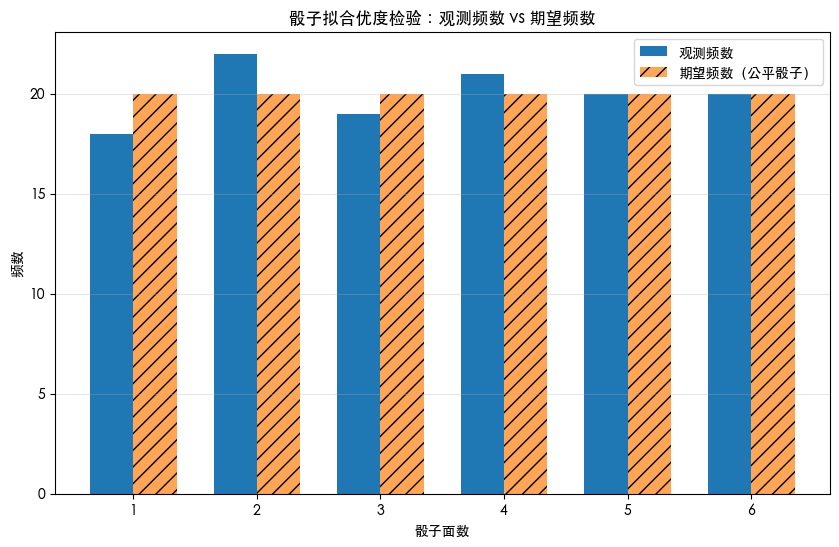

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# 已知数据
observed_die = np.array([18, 22, 19, 21, 20, 20])
n_die = np.sum(observed_die)
k_die = len(observed_die)
alpha_die = 0.05

# 1. 期望频数（公平骰子，每面概率1/6）
p_die = np.ones(k_die) / k_die
expected_die = n_die * p_die

# 2. 手动计算卡方统计量与自由度
chi2_stat_die = np.sum((observed_die - expected_die) ** 2 / expected_die)
df_die = k_die - 1

# 3. 临界值与手动 p 值
chi2_critical_die = stats.chi2.ppf(1 - alpha_die, df_die)
p_value_die = 1 - stats.chi2.cdf(chi2_stat_die, df_die)

# 4. 用 scipy.stats.chisquare 验证（注意返回值：statistic, pvalue）
# 我显式传入了 expected（f_exp）以避免 scipy 自动计算期望时的歧义
chi2_res = stats.chisquare(observed_die, f_exp=expected_die)
chi2_scipy = chi2_res.statistic
p_value_scipy = chi2_res.pvalue

# 输出结果
print("=== 骰子拟合优度检验结果 ===")
print(f"观测频数：{observed_die}")
print(f"期望频数：{expected_die.round(2)}")
print(f"手动计算卡方统计量：{chi2_stat_die:.4f}")
print(f"scipy.stats.chisquare 返回的卡方统计量：{chi2_scipy:.4f}")
print(f"自由度：{df_die}")
print(f"临界值（α={alpha_die}，df={df_die}）：{chi2_critical_die:.4f}")
print(f"手动计算 p 值：{p_value_die:.6f}")
print(f"scipy 返回的 p 值：{p_value_scipy:.6f}")
print("是否拒绝原假设 H0（骰子公平）：" +
      ("是" if (chi2_stat_die > chi2_critical_die) or (p_value_die < alpha_die) else "否"))
print("结论：" +
      ("骰子不公平" if (chi2_stat_die > chi2_critical_die) or (p_value_die < alpha_die)
       else "无足够证据表明骰子不公平"))

# 绘图（与原来相同）
faces = np.arange(1, k_die + 1)
x_pos = np.arange(len(faces))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x_pos - width/2, observed_die, width, label='观测频数')
plt.bar(x_pos + width/2, expected_die, width, label='期望频数（公平骰子）', hatch='//', alpha=0.7)
plt.xlabel('骰子面数')
plt.ylabel('频数')
plt.title('骰子拟合优度检验：观测频数 vs 期望频数')
plt.xticks(x_pos, faces)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.show()


## 3.2 独立性检验（性别与政策支持）
### 问题背景
200名选民的性别-政策支持交叉表，检验性别与政策支持是否独立（α=0.05）。

#### 解题思路
1. **假设建立**：  
   - $H_0$：性别与政策支持独立；  
   - $H_1$：性别与政策支持不独立。  
2. **期望频数**：$E_{ij} = \frac{\text{第i行合计} \times \text{第j列合计}}{\text{总样本数}}$（$i$为行，$j$为列）。  
3. **卡方统计量**：$\chi^2 = \sum_{i,j} \frac{(O_{ij} - E_{ij})^2}{E_{ij}}$，服从$\chi^2((r-1)(c-1))$分布（$r$为行数，$c$为列数）。  
4. **拒绝域**：$\chi^2 > \chi^2_{\alpha}((r-1)(c-1))$。

#### 核心公式
1. 期望频数：$E_{ij} = \frac{R_i \times C_j}{N}$（$R_i$行合计，$C_j$列合计，$N$总样本）；  
2. 卡方统计量：$\chi^2 = \sum_{i,j} \frac{(O_{ij} - E_{ij})^2}{E_{ij}}$；  
3. 自由度：$df = (r-1)(c-1)$。


=== 性别与政策支持独立性检验结果 ===
观测频数交叉表：
        Support  Oppose  Neutral
Male         50      20       10
Female       40      50       30

期望频数交叉表（保留2位小数）：
        Support  Oppose  Neutral
Male       36.0    28.0     16.0
Female     54.0    42.0     24.0

手动计算卡方统计量：16.6336
scipy计算卡方统计量：16.6336
自由度：2
临界值（α=0.05）：5.9915
p值：0.0002
是否拒绝原假设H0（独立）：是
结论：性别与政策支持不独立


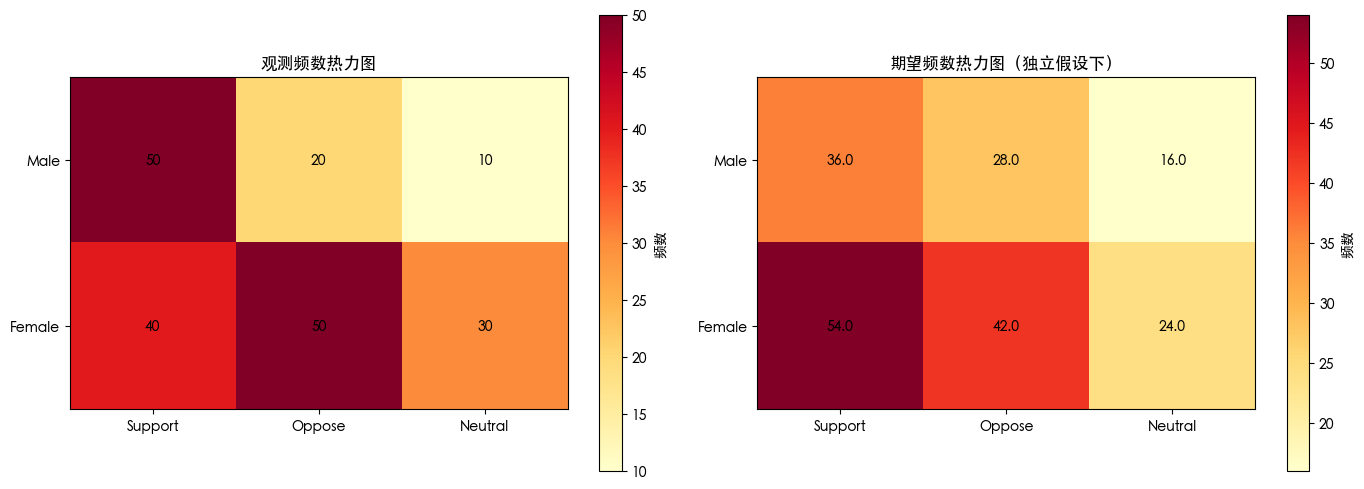

In [9]:
# 1. 构建交叉表（观测频数）
# 行：Male, Female；列：Support, Oppose, Neutral
observed_indep = np.array([
    [50, 20, 10],  # Male
    [40, 50, 30]   # Female
])
r_indep = observed_indep.shape[0]  # 行数（2）
c_indep = observed_indep.shape[1]  # 列数（3）
N_indep = np.sum(observed_indep)  # 总样本数（200）
alpha_indep = 0.05  # 显著性水平

# 2. 计算行合计、列合计与期望频数
row_totals = np.sum(observed_indep, axis=1)  # 行合计：[80, 120]
col_totals = np.sum(observed_indep, axis=0)  # 列合计：[90, 70, 40]

# 手动计算期望频数
expected_indep = np.zeros_like(observed_indep, dtype=float)
for i in range(r_indep):
    for j in range(c_indep):
        expected_indep[i, j] = (row_totals[i] * col_totals[j]) / N_indep

# 3. 计算卡方统计量（手动与scipy验证）
chi2_stat_indep = np.sum((observed_indep - expected_indep) ** 2 / expected_indep)
df_indep = (r_indep - 1) * (c_indep - 1)  # 自由度：(2-1)(3-1)=2

# scipy验证
chi2_scipy_indep, p_value_scipy_indep, df_scipy_indep, expected_scipy_indep = stats.chi2_contingency(observed_indep)

# 4. 计算临界值与p值
chi2_critical_indep = chi2.ppf(1 - alpha_indep, df_indep)
p_value_indep = 1 - chi2.cdf(chi2_stat_indep, df_indep)

# 输出结果
print("\n=== 性别与政策支持独立性检验结果 ===")
print("观测频数交叉表：")
print(pd.DataFrame(observed_indep, index=['Male', 'Female'], columns=['Support', 'Oppose', 'Neutral']))
print("\n期望频数交叉表（保留2位小数）：")
print(pd.DataFrame(expected_indep.round(2), index=['Male', 'Female'], columns=['Support', 'Oppose', 'Neutral']))
print(f"\n手动计算卡方统计量：{chi2_stat_indep:.4f}")
print(f"scipy计算卡方统计量：{chi2_scipy_indep:.4f}")
print(f"自由度：{df_indep}")
print(f"临界值（α={alpha_indep}）：{chi2_critical_indep:.4f}")
print(f"p值：{p_value_indep:.4f}")
print(f"是否拒绝原假设H0（独立）：{'是' if (chi2_stat_indep > chi2_critical_indep) or (p_value_indep < alpha_indep) else '否'}")
print(f"结论：{'性别与政策支持不独立' if (chi2_stat_indep > chi2_critical_indep) or (p_value_indep < alpha_indep) else '无足够证据表明性别与政策支持不独立'}")

# 绘制观测vs期望频数热力图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# 观测频数热力图
im1 = ax1.imshow(observed_indep, cmap='YlOrRd')
ax1.set_title('观测频数热力图')
ax1.set_xticks(range(c_indep))
ax1.set_xticklabels(['Support', 'Oppose', 'Neutral'])
ax1.set_yticks(range(r_indep))
ax1.set_yticklabels(['Male', 'Female'])
# 添加数值标签
for i in range(r_indep):
    for j in range(c_indep):
        ax1.text(j, i, observed_indep[i, j], ha='center', va='center', color='black')

# 期望频数热力图
im2 = ax2.imshow(expected_indep, cmap='YlOrRd')
ax2.set_title('期望频数热力图（独立假设下）')
ax2.set_xticks(range(c_indep))
ax2.set_xticklabels(['Support', 'Oppose', 'Neutral'])
ax2.set_yticks(range(r_indep))
ax2.set_yticklabels(['Male', 'Female'])
# 添加数值标签
for i in range(r_indep):
    for j in range(c_indep):
        ax2.text(j, i, f'{expected_indep[i, j]:.1f}', ha='center', va='center', color='black')

# 添加颜色条
cbar1 = plt.colorbar(im1, ax=ax1)
cbar2 = plt.colorbar(im2, ax=ax2)
cbar1.set_label('频数')
cbar2.set_label('频数')

plt.tight_layout()
plt.show()

# Question 4: 贝叶斯估计（Gamma先验+Exponential似然）
## 问题背景
$\theta \sim \text{Gamma}(\alpha=2, \beta=1)$，$X_1,...,X_n \sim \text{Exp}(\theta)$（指数分布率参数θ），需推导指数PDF和θ的后验分布。

### Part (a): 指数分布的PDF
#### 解题思路
指数分布（率参数θ）描述“事件发生的时间间隔”，其概率密度函数（PDF）需满足：  
1. 定义域：$x > 0$（时间非负）；  
2. 积分等于1（概率总和为1）；  
3. 均值为$1/\theta$（率参数越大，事件发生越频繁，间隔越短）。

#### 核心公式
指数分布（率参数θ）的PDF：  
$f(x|\theta) = \theta e^{-\theta x}$，其中$x > 0$，$\theta > 0$。

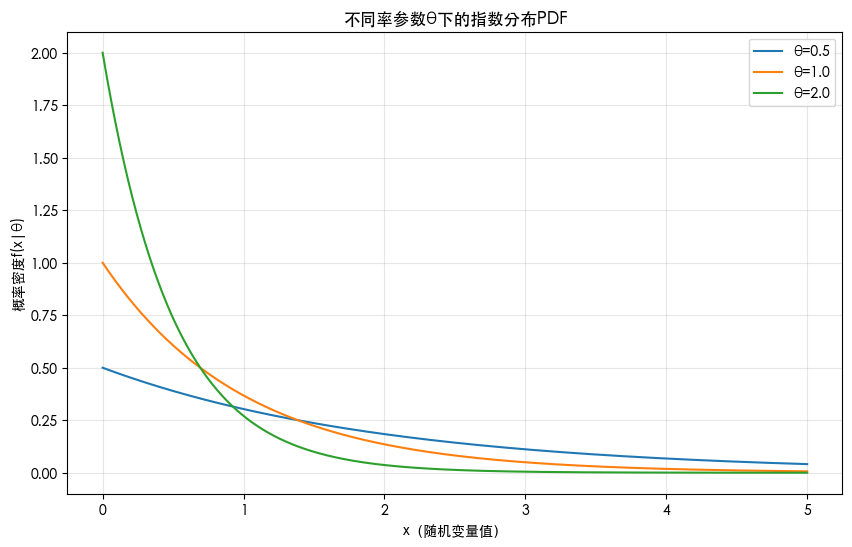

θ=1.0时，指数PDF在[0,5]上的积分（近似1）：0.9933


In [11]:
# 指数分布PDF定义
def exp_pdf(x, theta):
    """指数分布（率参数θ）的PDF"""
    return theta * np.exp(-theta * x) if x >= 0 else 0

# 可视化不同θ下的指数PDF
x_exp = np.linspace(0, 5, 1000)
theta_exp_values = [0.5, 1.0, 2.0]  # 不同的率参数
labels_exp = [f'θ={theta}' for theta in theta_exp_values]

plt.figure(figsize=(10, 6))
for theta, label in zip(theta_exp_values, labels_exp):
    y_exp = [exp_pdf(x, theta) for x in x_exp]
    plt.plot(x_exp, y_exp, label=label)

plt.xlabel('x（随机变量值）')
plt.ylabel('概率密度f(x|θ)')
plt.title('不同率参数θ下的指数分布PDF')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 验证PDF积分等于1（数值积分）
theta_test = 1.0
integral_exp = np.trapezoid([exp_pdf(x, theta_test) for x in x_exp], x_exp)
print(f"θ={theta_test}时，指数PDF在[0,5]上的积分（近似1）：{integral_exp:.4f}")

### Part (b): θ的后验分布推导
#### 解题思路
1. **贝叶斯公式**：后验 ∝ 似然 × 先验（忽略与θ无关的常数），即 $\pi(\theta|\mathbf{x}) \propto L(\mathbf{x}|\theta) \cdot \pi(\theta)$。  
2. **似然函数**：n个IID指数样本的似然为 $L(\mathbf{x}|\theta) = \prod_{i=1}^n f(x_i|\theta) = \theta^n e^{-\theta \sum x_i}$。  
3. **先验分布**：$\pi(\theta) \sim \text{Gamma}(\alpha=2, \beta=1)$，其PDF核为 $\theta^{\alpha-1} e^{-\beta \theta} = \theta^{1} e^{-\theta}$（忽略常数$\beta^\alpha/\Gamma(\alpha)$）。  
4. **后验核**：似然×先验 = $\theta^n e^{-\theta n\bar{x}} \cdot \theta e^{-\theta} = \theta^{n+1} e^{-\theta(n\bar{x}+1)}$，匹配Gamma分布核$\theta^{\alpha'-1} e^{-\beta'\theta}$，得后验$\pi(\theta|\mathbf{x}) \sim \text{Gamma}(\alpha'=n+2, \beta'=n\bar{x}+1)$。

#### 核心公式
1. 似然函数：$L(\mathbf{x}|\theta) = \theta^n e^{-\theta n\bar{x}}$（$\bar{x} = \frac{1}{n}\sum x_i$为样本均值）；  
2. 先验核：$\theta^{\alpha-1} e^{-\beta \theta} = \theta^{1} e^{-\theta}$；  
3. 后验核：$\theta^{(n+2)-1} e^{-(n\bar{x}+1)\theta}$；  
4. 后验分布：$\pi(\theta|\mathbf{x}) \sim \text{Gamma}(\alpha'=n+2, \beta'=n\bar{x}+1)$。

=== 贝叶斯估计：后验分布参数 ===
样本量n：10
生成数据的真实θ：1.5
样本均值bar(x)：0.6999
先验分布：Gamma(α=2, β=1)
后验分布：Gamma(α'=12, β'=7.9987)


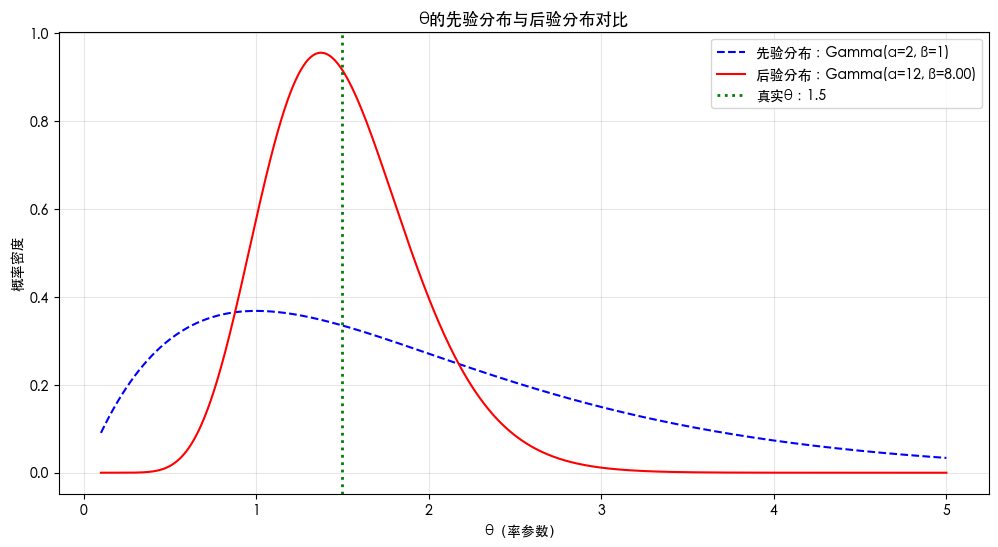


后验均值（α'/β'）：1.5003
先验均值（α/β）：2.0000
样本均值的倒数（经验估计）：1.4288


In [12]:
# 生成模拟数据（指数分布样本）
n_bayes = 10  # 样本量
theta_true_bayes = 1.5  # 真实的θ（用于生成数据）
x_bayes = expon.rvs(scale=1/theta_true_bayes, size=n_bayes)  # expon.rvs(scale=1/θ)
x_bar_bayes = np.mean(x_bayes)  # 样本均值

# 计算后验分布参数
alpha_prior = 2  # 先验Gamma的α
beta_prior = 1   # 先验Gamma的β
alpha_post = alpha_prior + n_bayes  # 后验Gamma的α' = 2 + n
beta_post = beta_prior + n_bayes * x_bar_bayes  # 后验Gamma的β' = 1 + n*bar(x)

# 输出关键参数
print("=== 贝叶斯估计：后验分布参数 ===")
print(f"样本量n：{n_bayes}")
print(f"生成数据的真实θ：{theta_true_bayes}")
print(f"样本均值bar(x)：{x_bar_bayes:.4f}")
print(f"先验分布：Gamma(α={alpha_prior}, β={beta_prior})")
print(f"后验分布：Gamma(α'={alpha_post}, β'={beta_post:.4f})")

# 可视化先验与后验分布
theta_bayes = np.linspace(0.1, 5, 1000)
prior_pdf = gamma.pdf(theta_bayes, a=alpha_prior, scale=1/beta_prior)  # Gamma(a, scale=1/β)
post_pdf = gamma.pdf(theta_bayes, a=alpha_post, scale=1/beta_post)

plt.figure(figsize=(12, 6))
plt.plot(theta_bayes, prior_pdf, label=f'先验分布：Gamma(α={alpha_prior}, β={beta_prior})', linestyle='--', color='blue')
plt.plot(theta_bayes, post_pdf, label=f'后验分布：Gamma(α={alpha_post}, β={beta_post:.2f})', color='red')
plt.axvline(theta_true_bayes, color='green', linestyle=':', linewidth=2, label=f'真实θ：{theta_true_bayes}')

plt.xlabel('θ（率参数）')
plt.ylabel('概率密度')
plt.title('θ的先验分布与后验分布对比')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 计算后验均值（Gamma分布均值为α/β）
post_mean = alpha_post / beta_post
print(f"\n后验均值（α'/β'）：{post_mean:.4f}")
print(f"先验均值（α/β）：{alpha_prior / beta_prior:.4f}")
print(f"样本均值的倒数（经验估计）：{1/x_bar_bayes:.4f}")

# Question 5: 贝叶斯决策理论（离散参数与数据）
## 问题背景
$\theta \in \{0,1\}$（先验$\pi(0)=p, \pi(1)=1-p$），$x \in \{0,1\}$（条件分布$f(x|\theta)$），损失函数$L(\theta,a)$，需计算风险、贝叶斯风险、贝叶斯规则及后验分布。

### Part (a): 风险函数$R(\theta, d)$计算
#### 解题思路
1. **风险函数定义**：对每个θ，风险为损失函数在数据分布上的期望：$R(\theta, d) = \mathbb{E}_{X|\theta}[L(\theta, d(X))] = \sum_{x=0}^1 L(\theta, d(x))f(x|\theta)$。  
2. **已知条件**：  
   - $f(x|0) = (2/3)^{1-x}(1/3)^x$（即$f(0|0)=2/3, f(1|0)=1/3$）；  
   - $f(x|1) = (1/4)^x(3/4)^{1-x}$（即$f(0|1)=3/4, f(1|1)=1/4$）；  
   - 损失函数：$L(0,a)=2(1-a), L(1,a)=3a$（$a=d(x)$为决策）。  
3. **分θ计算**：分别对$\theta=0$和$\theta=1$求和得风险。

#### 核心公式
1. $\theta=0$的风险：$R(0,d) = 2(1-d(0))\cdot \frac{2}{3} + 2(1-d(1))\cdot \frac{1}{3}$；  
2. $\theta=1$的风险：$R(1,d) = 3d(0)\cdot \frac{3}{4} + 3d(1)\cdot \frac{1}{4}$。

=== 风险函数计算示例（Part a）===
决策规则：d(0)=0.5, d(1)=0.5
R(0,d)（θ=0时的风险）：1.0000
R(1,d)（θ=1时的风险）：1.5000


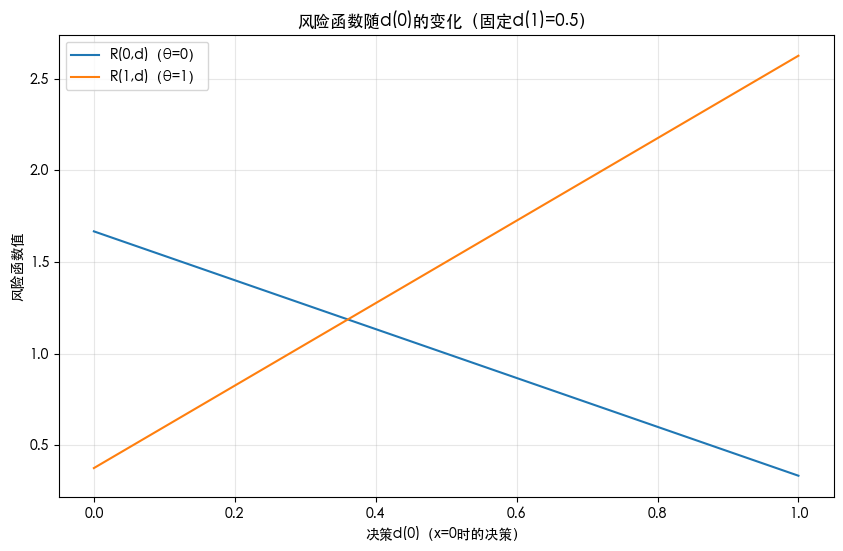

In [13]:
def loss_function(theta, a):
    """损失函数：L(θ,a)"""
    if theta == 0:
        return 2 * (1 - a)
    elif theta == 1:
        return 3 * a
    else:
        raise ValueError("θ must be 0 or 1")

def cond_prob(x, theta):
    """条件概率f(x|θ)"""
    if theta == 0:
        return (2/3) if x == 0 else (1/3)
    elif theta == 1:
        return (3/4) if x == 0 else (1/4)
    else:
        raise ValueError("θ must be 0 or 1")

def risk_function(theta, d0, d1):
    """风险函数R(θ,d)：d0=d(0), d1=d(1)"""
    # 对x=0和x=1求和
    risk = 0
    for x in [0, 1]:
        a = d0 if x == 0 else d1
        risk += loss_function(theta, a) * cond_prob(x, theta)
    return risk

# 示例：计算特定决策下的风险（d0=0.5, d1=0.5）
d0_example = 0.5
d1_example = 0.5
risk_0 = risk_function(0, d0_example, d1_example)
risk_1 = risk_function(1, d0_example, d1_example)

print("=== 风险函数计算示例（Part a）===")
print(f"决策规则：d(0)={d0_example}, d(1)={d1_example}")
print(f"R(0,d)（θ=0时的风险）：{risk_0:.4f}")
print(f"R(1,d)（θ=1时的风险）：{risk_1:.4f}")

# 可视化风险随d0的变化（固定d1=0.5）
d0_range = np.linspace(0, 1, 100)
risk0_range = [risk_function(0, d0, 0.5) for d0 in d0_range]
risk1_range = [risk_function(1, d0, 0.5) for d0 in d0_range]

plt.figure(figsize=(10, 6))
plt.plot(d0_range, risk0_range, label='R(0,d)（θ=0）')
plt.plot(d0_range, risk1_range, label='R(1,d)（θ=1）')
plt.xlabel('决策d(0)（x=0时的决策）')
plt.ylabel('风险函数值')
plt.title('风险函数随d(0)的变化（固定d(1)=0.5）')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Part (b): 贝叶斯风险$r(\pi,d)$推导
#### 解题思路
1. **贝叶斯风险定义**：风险函数在prior上的期望：$r(\pi,d) = \pi(0)R(0,d) + \pi(1)R(1,d)$。  
2. **代入风险函数**：将Part (a)的$R(0,d)$和$R(1,d)$代入，整理为$A \cdot d(0) + B \cdot d(1) + C$形式（A、B、C为关于p的系数）。

#### 核心公式
贝叶斯风险展开与整理：  
$$
r(\pi, d)
= p \cdot \frac{4(1 - d_0) + 2(1 - d_1)}{3}
+ (1 - p) \cdot \frac{9 d_0 + 3 d_1}{4}
= \underbrace{\left( \frac{27 - 43p}{12} \right)}_{A} d_0
+ \underbrace{\left( \frac{9 - 17p}{12} \right)}_{B} d_1
+ \underbrace{2p}_{C}
$$

其中 $d_0 = d(0),\; d_1 = d(1)$。



=== 贝叶斯风险计算示例（Part b）===
先验概率p=π(0)：0.5
决策规则：d(0)=0.3, d(1)=0.7
直接计算的贝叶斯风险：1.1667
整理形式验证的贝叶斯风险：1.1667
两种方法差异：0.0000000000（应接近0）


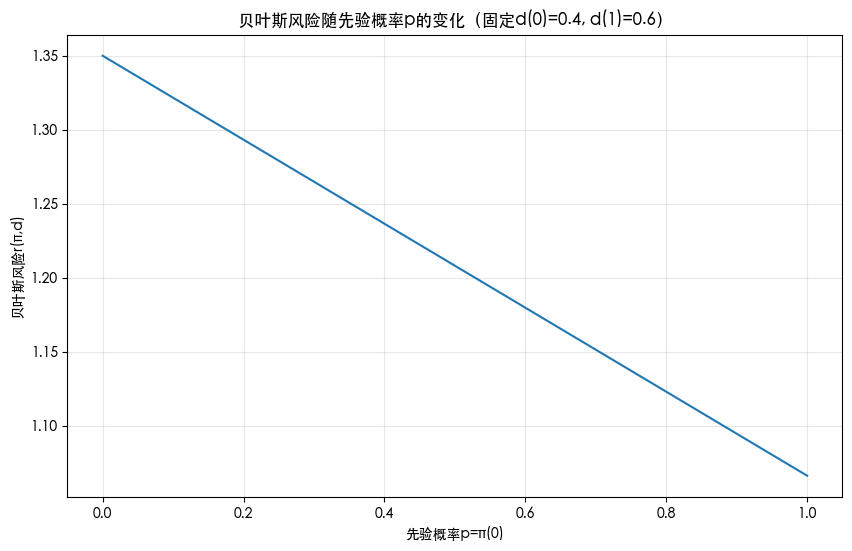

In [15]:
def bayes_risk(p, d0, d1):
    """贝叶斯风险r(π,d)：p=π(0)"""
    # 方法1：直接用定义计算
    risk0 = risk_function(0, d0, d1)
    risk1 = risk_function(1, d0, d1)
    bayes_r = p * risk0 + (1 - p) * risk1
    
    # 方法2：用整理后的形式验证
    A = (27 - 43 * p) / 12
    B = (9 - 17 * p) / 12
    C = 2 * p
    bayes_r_verified = A * d0 + B * d1 + C
    
    return bayes_r, bayes_r_verified

# 示例：p=0.5，d0=0.3，d1=0.7时的贝叶斯风险
p_example = 0.5
d0_example = 0.3
d1_example = 0.7
r1, r2 = bayes_risk(p_example, d0_example, d1_example)

print("\n=== 贝叶斯风险计算示例（Part b）===")
print(f"先验概率p=π(0)：{p_example}")
print(f"决策规则：d(0)={d0_example}, d(1)={d1_example}")
print(f"直接计算的贝叶斯风险：{r1:.4f}")
print(f"整理形式验证的贝叶斯风险：{r2:.4f}")
print(f"两种方法差异：{abs(r1 - r2):.10f}（应接近0）")

# 可视化贝叶斯风险随p的变化（固定d0=0.4, d1=0.6）
p_range = np.linspace(0, 1, 100)
bayes_r_range = [bayes_risk(p, 0.4, 0.6)[0] for p in p_range]

plt.figure(figsize=(10, 6))
plt.plot(p_range, bayes_r_range)
plt.xlabel('先验概率p=π(0)')
plt.ylabel('贝叶斯风险r(π,d)')
plt.title('贝叶斯风险随先验概率p的变化（固定d(0)=0.4, d(1)=0.6）')
plt.grid(True, alpha=0.3)
plt.show()

### Part (c): 贝叶斯规则求解
#### 解题思路
1. **贝叶斯规则定义**：最小化贝叶斯风险的决策规则$d_B(0), d_B(1)$。  
2. **最小化逻辑**：贝叶斯风险是$d0$和$d1$的线性函数，系数符号决定最小值：  
   - 若系数A < 0：$d0$越大，风险越小，取$d0=1$；  
   - 若系数A > 0：$d0$越小，风险越小，取$d0=0$；  
   - 同理对系数B判断$d1$。  
3. **临界p值**：令A=0得$p=27/43≈0.6279$，令B=0得$p=9/17≈0.5294$，分区间确定$d_B(0), d_B(1)$。

#### 核心公式
1. 系数A临界值：$\frac{27-43p}{12}=0 \implies p=\frac{27}{43}$；  
2. 系数B临界值：$\frac{9-17p}{12}=0 \implies p=\frac{9}{17}$。


=== 贝叶斯规则求解结果（Part c）===
临界p值1（B=0）：9/17≈0.5294
临界p值2（A=0）：27/43≈0.6279

不同p值对应的贝叶斯规则：
p=0.3：A=1.1750, B=0.3250 → d_B(0)=0, d_B(1)=0
p=0.6：A=0.1000, B=-0.1000 → d_B(0)=0, d_B(1)=1
p=0.7：A=-0.2583, B=-0.2417 → d_B(0)=1, d_B(1)=1

贝叶斯规则与先验概率p的关系表：
| p区间                | d_B(0) | d_B(1) |
|-----------------------|--------|--------|
| 0 ≤ p < 0.5294        | 0      | 0      |
| 0.5294 ≤ p < 0.6279   | 0      | 1      |
| 0.6279 ≤ p ≤ 1        | 1      | 1      |


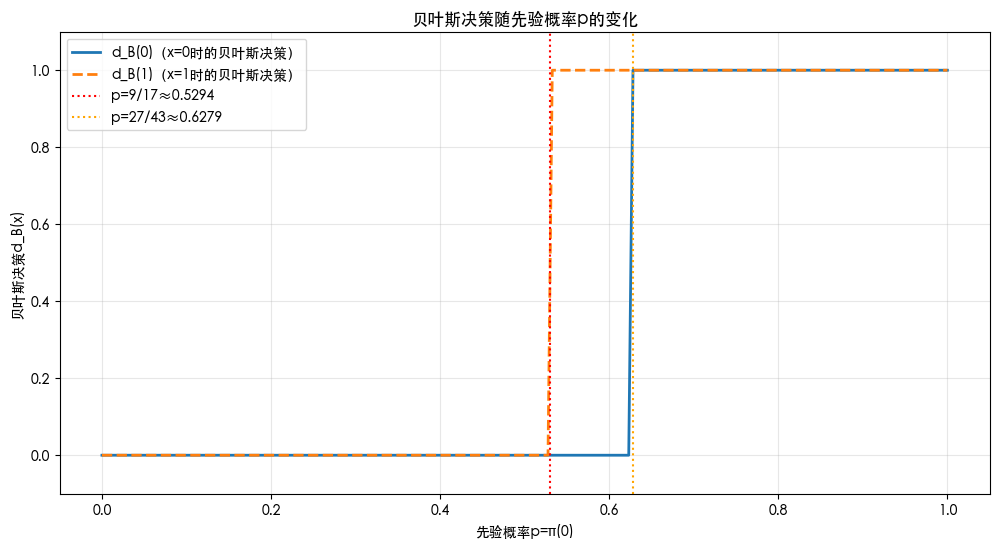

In [16]:
def bayes_rule(p):
    """求解贝叶斯规则d_B(0), d_B(1)"""
    # 计算系数A和B
    A = (27 - 43 * p) / 12
    B = (9 - 17 * p) / 12
    
    # 根据系数符号确定决策（线性函数最小化：系数<0取1，>0取0）
    d0_bayes = 1 if A < 0 else 0
    d1_bayes = 1 if B < 0 else 0
    
    # 临界值处理（A=0或B=0时，d可任意，此处取0.5）
    if abs(A) < 1e-10:
        d0_bayes = 0.5
    if abs(B) < 1e-10:
        d1_bayes = 0.5
    
    return d0_bayes, d1_bayes, A, B

# 计算不同p区间的贝叶斯规则
p_critical1 = 9 / 17  # B=0的临界p≈0.5294
p_critical2 = 27 / 43  # A=0的临界p≈0.6279
p_test_points = [0.3, 0.6, 0.7]  # 不同区间的p值

print("\n=== 贝叶斯规则求解结果（Part c）===")
print(f"临界p值1（B=0）：9/17≈{p_critical1:.4f}")
print(f"临界p值2（A=0）：27/43≈{p_critical2:.4f}")
print("\n不同p值对应的贝叶斯规则：")
for p in p_test_points:
    d0, d1, A, B = bayes_rule(p)
    print(f"p={p:.1f}：A={A:.4f}, B={B:.4f} → d_B(0)={d0}, d_B(1)={d1}")

# 生成贝叶斯规则表
p_intervals = [
    (0, p_critical1, f"0 ≤ p < {p_critical1:.4f}"),
    (p_critical1, p_critical2, f"{p_critical1:.4f} ≤ p < {p_critical2:.4f}"),
    (p_critical2, 1, f"{p_critical2:.4f} ≤ p ≤ 1")
]

print("\n贝叶斯规则与先验概率p的关系表：")
print("| p区间                | d_B(0) | d_B(1) |")
print("|-----------------------|--------|--------|")
for start, end, label in p_intervals:
    p_mid = (start + end) / 2
    d0, d1, _, _ = bayes_rule(p_mid)
    print(f"| {label:<21} | {d0:<6} | {d1:<6} |")

# 可视化贝叶斯决策随p的变化
p_continuous = np.linspace(0, 1, 200)
d0_continuous = [bayes_rule(p)[0] for p in p_continuous]
d1_continuous = [bayes_rule(p)[1] for p in p_continuous]

plt.figure(figsize=(12, 6))
plt.plot(p_continuous, d0_continuous, label='d_B(0)（x=0时的贝叶斯决策）', linewidth=2)
plt.plot(p_continuous, d1_continuous, label='d_B(1)（x=1时的贝叶斯决策）', linewidth=2, linestyle='--')
plt.axvline(p_critical1, color='red', linestyle=':', label=f'p=9/17≈{p_critical1:.4f}')
plt.axvline(p_critical2, color='orange', linestyle=':', label=f'p=27/43≈{p_critical2:.4f}')

plt.xlabel('先验概率p=π(0)')
plt.ylabel('贝叶斯决策d_B(x)')
plt.title('贝叶斯决策随先验概率p的变化')
plt.ylim(-0.1, 1.1)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Part (d): 后验分布$\pi(\theta|x)$计算
#### 解题思路
1. **后验概率公式**：由贝叶斯公式，$\pi(\theta|x) = \frac{f(x|\theta)\pi(\theta)}{f(x)}$，其中$f(x) = f(x|0)\pi(0) + f(x|1)\pi(1)$（边际概率）。  
2. **分x计算**：分别对$x=0$和$x=1$计算$\pi(0|x)$和$\pi(1|x)$（注意$\pi(0|x) + \pi(1|x) = 1$）。

#### 核心公式
1. 边际概率：$f(x) = f(x|0)p + f(x|1)(1-p)$；  
2. 后验概率：$\pi(0|x) = \frac{f(x|0)p}{f(x)}$，$\pi(1|x) = 1 - \pi(0|x)$。


=== 后验分布计算示例（Part d）===
先验概率p=π(0)：0.6
x=0时的后验分布：π(0|0)=0.5714, π(1|0)=0.4286
x=1时的后验分布：π(0|1)=0.6667, π(1|1)=0.3333


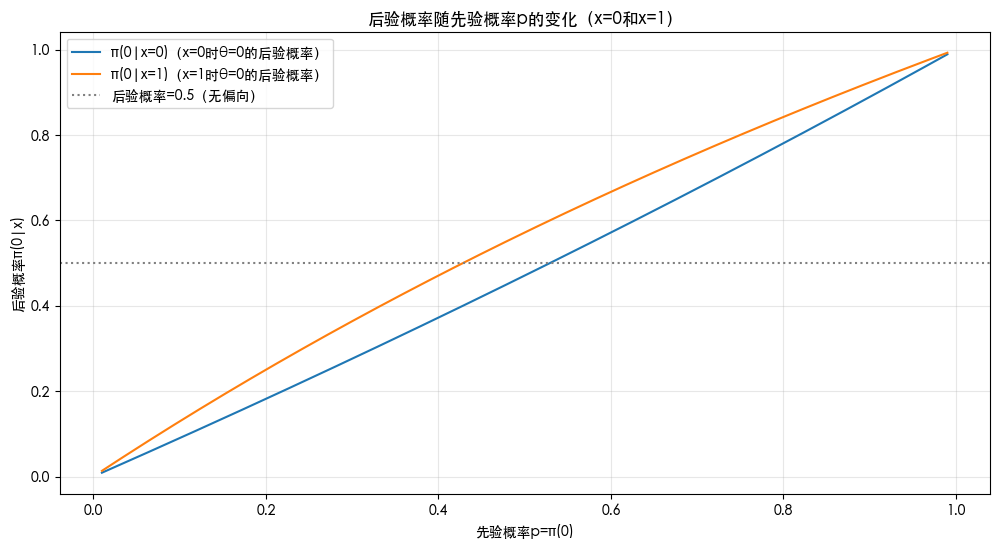

In [17]:
def marginal_prob(x, p):
    """边际概率f(x) = f(x|0)p + f(x|1)(1-p)"""
    return cond_prob(x, 0) * p + cond_prob(x, 1) * (1 - p)

def posterior_dist(x, p):
    """后验分布π(θ|x)：返回(π(0|x), π(1|x))"""
    f_x = marginal_prob(x, p)
    post0 = (cond_prob(x, 0) * p) / f_x
    post1 = 1 - post0
    return post0, post1

# 示例：p=0.6时，x=0和x=1的后验分布
p_example_d = 0.6
post0_x0, post1_x0 = posterior_dist(0, p_example_d)
post0_x1, post1_x1 = posterior_dist(1, p_example_d)

print("\n=== 后验分布计算示例（Part d）===")
print(f"先验概率p=π(0)：{p_example_d}")
print(f"x=0时的后验分布：π(0|0)={post0_x0:.4f}, π(1|0)={post1_x0:.4f}")
print(f"x=1时的后验分布：π(0|1)={post0_x1:.4f}, π(1|1)={post1_x1:.4f}")

# 可视化后验分布随p的变化（x=0和x=1）
p_post_range = np.linspace(0.01, 0.99, 200)  # 避免p=0或1导致分母为0
post0_x0_range = [posterior_dist(0, p)[0] for p in p_post_range]
post0_x1_range = [posterior_dist(1, p)[0] for p in p_post_range]

plt.figure(figsize=(12, 6))
plt.plot(p_post_range, post0_x0_range, label='π(0|x=0)（x=0时θ=0的后验概率）')
plt.plot(p_post_range, post0_x1_range, label='π(0|x=1)（x=1时θ=0的后验概率）')
plt.axhline(0.5, color='gray', linestyle=':', label='后验概率=0.5（无偏向）')
plt.xlabel('先验概率p=π(0)')
plt.ylabel('后验概率π(0|x)')
plt.title('后验概率随先验概率p的变化（x=0和x=1）')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Part (e): 后验期望损失最小化验证
#### 解题思路
1. **后验期望损失定义**：对给定x，损失函数在后验分布上的期望：$\mathbb{E}[L(\theta,a)|x] = L(0,a)\pi(0|x) + L(1,a)\pi(1|x)$。  
2. **最小化逻辑**：后验期望损失是a的线性函数，系数符号决定最小值（与贝叶斯规则一致），验证两者结果相同。

#### 核心公式
1. x=0的后验期望损失：$2(1-a)\pi(0|0) + 3a\pi(1|0)$；  
2. x=1的后验期望损失：$2(1-a)\pi(0|1) + 3a\pi(1|1)$。


=== 后验期望损失最小化验证（Part e）===
先验概率p=π(0)：0.6
贝叶斯规则 vs 后验期望损失最小化决策：
x=0：贝叶斯决策=0，后验期望损失最小决策=0 → 一致
x=1：贝叶斯决策=1，后验期望损失最小决策=1 → 一致


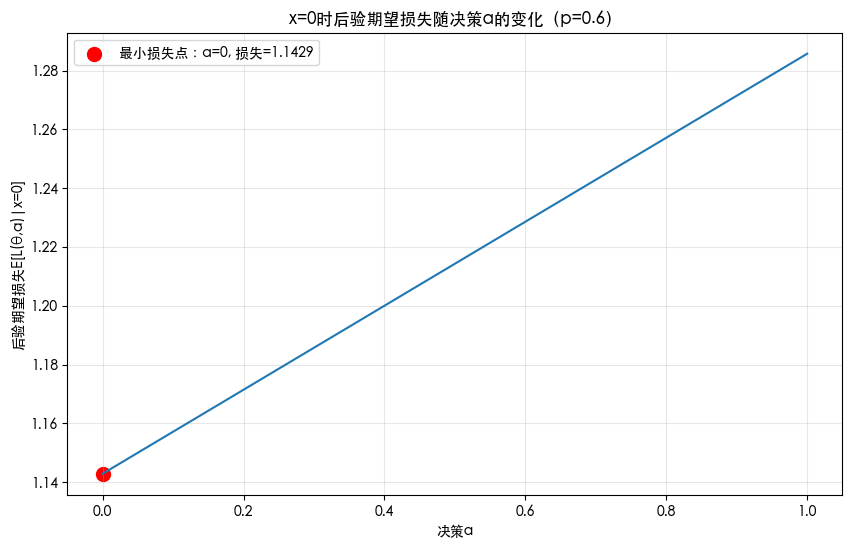

In [18]:
def posterior_expected_loss(x, p, a):
    """后验期望损失E[L(θ,a)|x]"""
    post0, post1 = posterior_dist(x, p)
    return loss_function(0, a) * post0 + loss_function(1, a) * post1

def min_posterior_loss(x, p):
    """最小化后验期望损失的决策a"""
    # 后验期望损失是a的线性函数：E = k0 + k1*a，最小化取决于k1的符号
    post0, post1 = posterior_dist(x, p)
    # 展开E[L|x] = 2(1-a)post0 + 3a post1 = 2post0 + a(3post1 - 2post0)
    k1 = 3 * post1 - 2 * post0  # 系数a的系数
    
    if k1 < 0:
        return 1  # a越大，E越小，取a=1
    elif k1 > 0:
        return 0  # a越小，E越小，取a=0
    else:
        return 0.5  # k1=0，任意a

# 验证：贝叶斯规则与后验期望损失最小化结果一致
p_verify = 0.6  # 示例p值
x_verify_list = [0, 1]

print("\n=== 后验期望损失最小化验证（Part e）===")
print(f"先验概率p=π(0)：{p_verify}")
print("贝叶斯规则 vs 后验期望损失最小化决策：")
for x in x_verify_list:
    # 贝叶斯规则的决策
    d_bayes_x = bayes_rule(p_verify)[0] if x == 0 else bayes_rule(p_verify)[1]
    # 后验期望损失最小化的决策
    d_pel_x = min_posterior_loss(x, p_verify)
    print(f"x={x}：贝叶斯决策={d_bayes_x}，后验期望损失最小决策={d_pel_x} → {'一致' if d_bayes_x == d_pel_x else '不一致'}")

# 可视化x=0时后验期望损失随a的变化（p=0.6）
x_vis = 0
p_vis = 0.6
a_range = np.linspace(0, 1, 100)
pel_range = [posterior_expected_loss(x_vis, p_vis, a) for a in a_range]
min_a = min_posterior_loss(x_vis, p_vis)
min_pel = posterior_expected_loss(x_vis, p_vis, min_a)

plt.figure(figsize=(10, 6))
plt.plot(a_range, pel_range)
plt.scatter(min_a, min_pel, color='red', s=100, label=f'最小损失点：a={min_a}, 损失={min_pel:.4f}')
plt.xlabel('决策a')
plt.ylabel('后验期望损失E[L(θ,a)|x=0]')
plt.title(f'x=0时后验期望损失随决策a的变化（p={p_vis}）')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()